In [2]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Conv2DTranspose
import matplotlib.pyplot as plt
%matplotlib inline

2023-05-03 17:13:06.829880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:13:07.378132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-03 17:13:07.378181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-03 17:13:07.378185: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Helper Functions

In [4]:
def show(image):
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

def generate_base_sample(img,scale):
    dim = (int(image.shape[1]*scale),int(image.shape[0]*scale))
    return cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

## Dataset Generator

In [5]:
# image = cv2.imread("test.jpg")
image = cv2.imread("./data/gate/frame_0001.png")

In [6]:
image.shape

(720, 1280, 3)

In [7]:
im = generate_base_sample(image,1/6)

In [8]:
im.shape

(120, 213, 3)

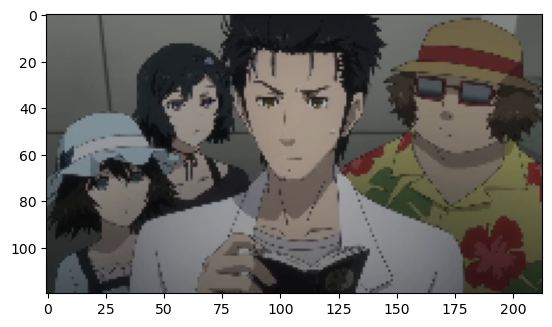

In [9]:
show(im)

In [10]:
cv2.imwrite("./data/frame1_lr.png",im)

True

In [11]:
# with tf.device("/device:CPU:0"):
im = np.divide(im,255.0)

tfimg = tf.constant(im,dtype=tf.float32)
tfones = tf.ones((im.shape[0]//2,im.shape[1]//2,1))

2023-05-03 17:13:08.375437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:13:08.740511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2913 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
tf.TensorSpec.from_tensor(tfimg)

TensorSpec(shape=(120, 213, 3), dtype=tf.float32, name=None)

In [13]:
tf.TensorSpec.from_tensor(tfones)

TensorSpec(shape=(60, 106, 1), dtype=tf.float32, name=None)

In [14]:
def sample_generator():
    base_image=im
    yield tf.ones((base_image.shape[0]//2,base_image.shape[1]//2,1)),tf.constant(base_image)

In [15]:
dataset = tf.data.Dataset.from_generator(sample_generator,
                                         output_signature=(
                                             tf.TensorSpec.from_tensor(tfones),
                                             tf.TensorSpec.from_tensor(tfimg)
                                         ))

In [16]:
dataset = dataset.repeat(16)
dataset = dataset.batch(8,num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
for i in dataset.take(2):
    print(i[0].shape)

(8, 60, 106, 1)
(8, 60, 106, 1)


## Model Creation

In [18]:
def create_model():
    # inp = Input((216,384,1))
    inp = Input((None,None,1))
    conv = Conv2DTranspose(64,(3,3),strides=(1,1),activation="relu",padding="same",name="conv64")(inp)
    conv = BatchNormalization()(conv)
    conv =  Conv2DTranspose(32,(3,3),strides=(1,1),activation="relu",padding="same",name="conv32")(conv)
    conv = BatchNormalization()(conv)
    conv =  Conv2DTranspose(32,(3,3),strides=(1,1),activation="relu",padding="same",name="conv321")(conv)
    conv = BatchNormalization()(conv)
    conv =  Conv2DTranspose(32,(3,3),strides=(1,1),activation="relu",padding="same",name="conv322")(conv)
    conv = BatchNormalization()(conv)
    conv =  Conv2DTranspose(32,(3,3),strides=(1,1),activation="relu",padding="same",name="conv323")(conv)
    conv = BatchNormalization()(conv)
    convfinal = Conv2D(3*(2**2),(3,3),strides=(1,1),activation="sigmoid",padding="same",name="convfinal")(conv)
    convfinal = tf.nn.depth_to_space(convfinal,2,name="SubPixelConv")
    return Model(inputs=inp,outputs=convfinal,name="SubPixelNIR")    

In [19]:
model = create_model()
model.summary()

Model: "SubPixelNIR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv64 (Conv2DTranspose)    (None, None, None, 64)    640       
                                                                 
 batch_normalization (BatchN  (None, None, None, 64)   256       
 ormalization)                                                   
                                                                 
 conv32 (Conv2DTranspose)    (None, None, None, 32)    18464     
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 32)   128       
 hNormalization)                                                 
                                                                 
 conv321 (Conv2DTranspose)   (None, None, None, 32)    

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss=tf.keras.losses.mean_squared_error)

In [21]:
checkpoint_filepath = './checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [22]:
model.fit(dataset,epochs=100,verbose=1,callbacks=[model_checkpoint_callback])

Epoch 1/100


ValueError: in user code:

    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/vinayak/anaconda3/envs/video/lib/python3.10/site-packages/keras/losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 212 and 213 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](SubPixelNIR/tf.nn.depth_to_space/DepthToSpace, IteratorGetNext:1)' with input shapes: [?,120,212,3], [?,120,213,3].
